In [2]:
import os
import glob
import logging
from tqdm import tqdm
from PIL import Image
from imageio import imwrite
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import skimage.morphology
from sklearn.model_selection import KFold, train_test_split
from skimage import io, transform
from skimage.filters import threshold_otsu

import torch
import torchvision

from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

#
import imgaug
from imgaug import augmenters as iaa
import random
import skimage
#

class Config():
    if torch.cuda.is_available():
        ROOT_FOLDER = '/content/.kaggle/competitions/data-science-bowl-2018/'
    else:
        ROOT_FOLDER = '/home/bilal/.kaggle/competitions/data-science-bowl-2018/'

    STAGE='1'

    IMGS_FOLDER = 'stage1_train'
    TARGETS_FOLDER = 'stage1_targets'

    SUBSET = False

    SHUFFLE = True
    BATCH_SIZE = 4
    NUM_WORKERS = 3

    KFOLDS = 6
    PATIENCE = 0
    EPOCHS = 10
    LR = 0.0001
    WEIGHTS = ''
    
    RANDOMCROP = 256
    FLIPLR = 0.5
    FLIPUD = 0.5
    ROTATE = 25

config = Config()

class EarlyStopping:
    def __init__(self):
        
        self.best_score = 1e10
        self.best_epoch = 0 

    def evaluate(self, model, loss, epoch, patience=0):
        if loss < self.best_score:
            logging.info('Val score has improved, saving model')
            self.best_score = loss
            self.best_epoch = epoch
            return 'save'
        elif epoch - self.best_epoch > patience:
            logging.info('Val score hasn\'t improved for ' + str(epoch - self.best_epoch) + ' epochs, stopping training')
            return 'stop'
        else:
            logging.info('Val score hasn\'t improved for ' + str(epoch - self.best_epoch) + ' epochs, not saving model')
            return 'continue'
    
def calculate_losses(total_train_loss, total_val_loss, train_ids, val_ids, epoch):
    train_loss = total_train_loss / (len(train_ids) / config.BATCH_SIZE)
    val_loss = total_val_loss / (len(val_ids) / config.BATCH_SIZE)

    message = 'Epoch # ' + str(epoch) + ' | Training Loss: ' + str(round(train_loss, 4)) + ' | Validation Loss: ' + str(round(val_loss, 4))
    
    return message, train_loss, val_loss

def calculate_kfolds_losses(total_kfolds_train_loss, total_kfolds_val_loss, kfolds, epochs):
    train_loss = total_kfolds_train_loss / (kfolds * epochs)
    val_loss = total_kfolds_val_loss / (kfolds * epochs)

    message = '\nTotal loss over ' + str(kfolds) + ' kfolds and ' + str(epochs) + ' epochs | Training Loss: ' + str(round(train_loss, 4)) + ' | Validation Loss: ' + str(round(val_loss, 4))
    return message

def save_model(model, kfold):
    torch.save(model.state_dict(), './model-kfold-' + str(kfold) + '-best.pt')

def load_model(model, path):
    logging.info('Loading saved model')
    model.load_state_dict(torch.load(path))

    return model

def get_kfolds(kfolds):
    if config.SUBSET:
        ids = glob.glob(os.path.join(config.ROOT_FOLDER, 'stage' + config.STAGE + '_train', '*'))[:20]
    else:
        ids = glob.glob(os.path.join(config.ROOT_FOLDER, 'stage' + config.STAGE + '_train', '*'))
        

    ids = [id.split('/')[-1] for id in ids]

    if kfolds == 1:
        train_ids, val_ids = train_test_split(ids, test_size=0.1)
        return [[train_ids, val_ids]]
    else:
        kf = KFold(n_splits=kfolds)

        kfolds = []
        for x, y in kf.split(ids):
            x = ids[x[0]: x[-1]]
            y = ids[y[0]: y[-1]]

            kfolds.append([x, y])

        return kfolds

def get_path(id):
    img_path = os.path.join(config.ROOT_FOLDER, 'stage' + config.STAGE + '_train', id, 'images', id + '.png')
    target_path = os.path.join('./targets', id + '.png')

    return img_path, target_path

def get_edges(img):
    img = skimage.morphology.binary_dilation(img, selem=np.ones((5,5))).astype(np.uint8)
    return img
 
#
def get_sizes(mask_folder):
    mask = glob.glob(os.path.join(mask_folder, 'masks/*'))[0]
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
 
    return mask.shape

def create_masks(root_folder, stage_number, stage_section, output_folder, mode, subset=False):
    stage_folder = os.path.join(root_folder, 'stage' + stage_number + '_' + stage_section) 
#     os.makedirs(stage_folder + '_' + mode, exist_ok=True)
    os.makedirs('./' + mode, exist_ok=True)

    if subset:
        masks_folder = glob.glob(os.path.join(stage_folder, '*'))[:20]
    else:
        masks_folder = glob.glob(os.path.join(stage_folder, '*'))        
    
    for mask_folder in tqdm(masks_folder):
        mask_id = mask_folder.split('/')[-1]

        size = get_sizes(mask_folder)
        masks = np.zeros(size)
        masks_with_edges = np.zeros(size)

        for mask in glob.glob(os.path.join(mask_folder, 'masks/*')):
            ###
            img = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
            img = img / 255.0

            img_with_edges = get_edges(img)
            
            masks = np.add(masks, img)
            masks_with_edges = np.add(masks_with_edges, img_with_edges)
        
        target = np.zeros((size[0], size[1], 3))
        
        target[:,:,0] = masks == 1
        target[:,:,1] = masks_with_edges == 2
        target[:,:,2] = masks == 0
        
        target *= 255
        target = target.astype(np.uint8)

        output_path = os.path.join('./' + mode, mask_id + '.png')        
        imwrite(output_path, target)
        
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, pooling=True):
        super(ConvBlock, self).__init__()
        self.pooling = pooling
      
        self.conv = nn.Sequential(
          nn.Conv2d(in_ch, out_ch, 3, padding=1),
          nn.BatchNorm2d(out_ch),
          nn.ReLU(inplace=True),
          nn.Dropout2d(0.2),
          nn.Conv2d(out_ch, out_ch, 3, padding=1),
          nn.BatchNorm2d(out_ch),
          nn.ReLU(inplace=True),
          nn.Dropout2d(0.2)
        )
        
    def forward(self, x):
        x = self.conv(x)      
  
        if self.pooling == True:
            x = F.max_pool2d(x, 2)
                            
        return x

class Upsample(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch, pooling=False)

    def forward(self, x1, x2):
        upsample = self.upsample(x1)
        
        cat = torch.cat([x2, upsample], dim=1)
        conv = self.conv(cat)

        return conv

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()

        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        x = F.sigmoid(x)

        return x

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        self.in_conv = ConvBlock(3, 64, pooling=False)
        self.down_1 = ConvBlock(64, 128)
        self.down_2 = ConvBlock(128, 256)
        self.down_3 = ConvBlock(256, 512)
        self.down_4 = ConvBlock(512, 1024)
        self.up_1 = Upsample(1024, 512)
        self.up_2 = Upsample(512, 256)
        self.up_3 = Upsample(256, 128)
        self.up_4 = Upsample(128, 64)
        
        self.out_conv = OutConv(64, 3)

    def forward(self, x):
        x = x / 255
    
        x1 = self.in_conv(x)
        x2 = self.down_1(x1)
        x3 = self.down_2(x2)
        x4 = self.down_3(x3)
        x5 = self.down_4(x4)
        x = self.up_1(x5, x4)
        x = self.up_2(x, x3)
        x = self.up_3(x, x2)
        x = self.up_4(x, x1)
        
        outputs = self.out_conv(x)

        return outputs

class Resize(object):
    def __call__(self, sample, size):
        img, mask = sample[0], sample[1]

        img = skimage.transform.resize(img, (size, size), mode='reflect', preserve_range=True)
        mask = skimage.transform.resize(mask, (size, size), mode='reflect', preserve_range=True)

        img = img.astype(np.uint8)
        mask = mask.astype(np.uint8)

        return img, mask
        
class RandomCrop(object):
    def __call__(self, sample, size):
        img = sample[0]
        mask = sample[1]

        h, w = img.shape[:2]

        if h != size:
            top = np.random.randint(0, h - size)
            left = np.random.randint(0, w - size)
        else:
            top = 0
            left = 0

        img = img[top: top + size, left: left + size]
        mask = mask[top: top + size, left: left + size]

        return img, mask
    
# class CLAHE(object):
#     def __call__(self, sample):
#         img, mask = sample[0], sample[1]

#         img = img.reshape(256, 256, 3)
#         img = img[:,:,[2,1,0]] # flip r and b
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(grid_size,grid_size))
#         img[:,:,0] = clahe.apply(img[:,:,0])
#         img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
#         img = img[:,:,[2,1,0]]
#         img = img.reshape(3, 256, 256)
        
#         return img, mask
        
class RescalingIntensity(object):
    def __call__(self, sample):
        img, mask = sample[0], sample[1]
        
        img_gray = img[:,:,0]
        if np.mean(img_gray) > 127:
            img = 255 - img
    
        return img, mask

class FlipLR(object):
    def __call__(self, sample, p):
        img, mask = sample[0], sample[1]
        
        if random.random() < p:
            img = img[:, ::-1].copy()
            mask = mask[:, ::-1].copy()
            return img, mask
        return img, mask

class FlipUD(object):
    def __call__(self, sample, p):
        img, mask = sample[0], sample[1]
        
        if random.random() < p:
            img = img[::-1].copy()
            mask = mask[::-1].copy()
            return img, mask
        return img, mask

class Rotate(object):
    def __call__(self, sample, max_angle):
        img, mask = sample[0], sample[1]

        angle = random.randint(0, max_angle)
        
        img = skimage.transform.rotate(img, angle, preserve_range=True)
        mask = skimage.transform.rotate(mask, angle, preserve_range=True)
        
        img = img.astype(np.uint8)
        mask = mask.astype(np.uint8)

        return img, mask

class ToTensor(object):
    def __call__(self, sample):
        img, mask = sample[0], sample[1]
        
        img = transforms.ToTensor()(img)
        mask = transforms.ToTensor()(mask)
        
        return img, mask
    
class CLAHE(object):
    def __call__(self, sample):
        img, mask = sample[0], sample[1]

        img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
        img[:, :, 0] = clahe.apply(img[:, :, 0])
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        
        return img, mask

def augmentation(img, mask):
    randomCrop = RandomCrop()
    flipLR = FlipLR()
    flipUD = FlipUD()
    rotate = Rotate()
    
    img, mask = randomCrop([img, mask], config.RANDOMCROP)
    img, mask = flipLR([img, mask], config.FLIPLR)
    img, mask = flipUD([img, mask], config.FLIPUD)
    img, mask = rotate([img, mask], config.ROTATE)

    return img, mask

class TrainDataset(Dataset):
    def __init__(self, ids, augmentation=None):
        self.ids = ids
        self.augmentation = augmentation
        
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        id = self.ids[idx]

        img_path, targets_path = get_path(id)
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(targets_path, cv2.IMREAD_COLOR)
        
#         img, target = self.augmentation(img, target)
        
        clahe = CLAHE()
        rescalingIntensity = RescalingIntensity()
        toTensor = ToTensor()
        randomCrop = RandomCrop()
        
#         img, mask = clahe([img, mask])
        img, mask = rescalingIntensity([img, mask])
        img, mask = rescalingIntensity([img, mask])
        img, mask = randomCrop([img, mask], config.RANDOMCROP)
        img, mask = toTensor([img, mask])

        return {'img': img, 'target': mask}
    
# Taken from Heng Cher Keng's April 27 code
class WeightedBCELoss2d(nn.Module):
    def __init__(self):
        super(WeightedBCELoss2d, self).__init__()

    def forward(self, logits, labels, weights):
        w = weights.view(-1)
        z = logits.contiguous().view(-1)
        t = labels.contiguous().view(-1)

        loss = w*z.clamp(min=0) - w*z*t + w*torch.log(1 + torch.exp(-z.abs()))
        loss = loss.sum()/(w.sum()+ 1e-12)
        return loss

def make_weight(labels_truth):
    B,C,H,W = labels_truth.size()
    weight = torch.FloatTensor(B*C*H*W).requires_grad_().cuda()

    pos = labels_truth.detach().sum()
    neg = B*C*H*W - pos
    
    if pos>0:
        pos_weight = 0.5/pos
        neg_weight = 0.5/neg
    else:
        pos_weight = 0
        neg_weight = 0

    weight[labels_truth.contiguous().view(-1)> 0.5] = pos_weight
    weight[labels_truth.contiguous().view(-1)<=0.5] = neg_weight

    weight = weight.view(B,C,H,W)
    return weight

def loss(inputs, targets):
    epsilon = 1e-5
    inputs = torch.clamp(inputs.cpu(), epsilon, 1. - epsilon)
    weight = 30 * targets[:,0:1].cpu() + 3 * targets[:,1:2].cpu() + 1 * targets[:,2:3].cpu()
    
    loss = - torch.sum(targets.cpu() * weight.cpu() * torch.log(inputs.cpu()) + (1 - targets.cpu()) * torch.log(1 - inputs.cpu()), 1)
  
    return loss

    # mask_weights = make_weight(targets[:,0:1])
    # edges_weights = make_weight(targets[:,1:2])
    # backgrounds_weights = make_weight(targets[:,2:3])

    # mask_loss = WeightedBCELoss2d()(inputs[:,0:1], targets[:,0:1], mask_weights)
    # edges_loss = WeightedBCELoss2d()(inputs[:,1:2], targets[:,1:2], edges_weights)
    # backgrounds_loss = WeightedBCELoss2d()(inputs[:,2:3], targets[:,2:3], backgrounds_weights)

    # loss = 3 * dice_loss(inputs[:,0:1], targets[:,0:1]) + 30 * dice_loss(inputs[:,1:2], targets[:,1:2]) + 1 * dice_loss(inputs[:,2:3], targets[:,2:3])

    return loss

def dice_loss(inputs, targets):
    num = targets.size(0)
    m1  = inputs.view(num,-1)
    m2  = targets.view(num,-1)
    intersection = (m1 * m2)
    score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
    score = 1 - score.sum()/num
    return score

def iou(predict, label):

    # Precision helper function
    def compute_precision(threshold, iou):
        matches = iou > threshold
        true_positives  = np.sum(matches, axis=1) == 1  # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    num_label   = len(np.unique(label  ))
    num_predict = len(np.unique(predict))

    # Compute intersection between all objects
    intersection = np.histogram2d(label.flatten(), predict.flatten(), bins=(num_label, num_predict))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(label,   bins = num_label  )[0]
    area_pred = np.histogram(predict, bins = num_predict)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred,  0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    precision = []
    average_precision = 0
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = compute_precision(t, iou)
        p = tp / (tp + fp + fn)
        precision.append((t, p, tp, fp, fn))
        average_precision += p

    average_precision /= len(precision)
    return average_precision, precision

def show_images(weights):
    logging.info('Visualizing model')
    model = Unet()
    model.load_state_dict(torch.load(weights))
    model.eval()

    model.cuda()
  
    kfolds = get_kfolds(2)
  
#     dataset = TrainDataset(kfolds[0][0], x_transform=x_transforms, target_transforms=target_transforms)
    dataset = TrainDataset(kfolds[0][0], augmentation=augmentation)
    dataLoader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)

    with torch.no_grad():
        for data in dataLoader:
            img, target = data['img'], data['target']

            x = Variable(img).cuda()
            y = Variable(target).cuda()

            outs = model(x)
            break

    y = y.detach().cpu().numpy()
    outs = outs.detach().cpu().numpy()

    fig = plt.figure(figsize=(30, 20))

    ax = plt.subplot(4, 4, 1)
    ax.set_title('Ground truth')
    ax.imshow(y[1].reshape(256, 256, 3))

    ax = plt.subplot(4, 4, 2)
    ax.set_title('Ground truth mask')
    ax.imshow(y[1][0].reshape(256, 256))

    ax = plt.subplot(4, 4, 3)
    ax.set_title('Ground truth edges')
    ax.imshow(y[1][1].reshape(256, 256))

    ax = plt.subplot(4, 4, 4)
    ax.set_title('Ground truth background')
    ax.imshow(y[1][2].reshape(256, 256))

    ax = plt.subplot(4, 4, 5)
    ax.set_title('Ground truth mask - edges')
    ax.imshow((y[1][0] - y[1][1]).reshape(256, 256))

    ax = plt.subplot(4, 4, 6)
    ax.set_title('Ground truth background - mask')
    ax.imshow((y[1][2] - y[1][0]).reshape(256, 256))

    ax = plt.subplot(4, 4, 7)
    ax.set_title('Predicted mask')
    ax.imshow((outs[1][0]).reshape(256, 256))

    ax = plt.subplot(4, 4, 8)
    ax.set_title('Predicted mask with Otsu thresholding')
    ax.imshow((outs[1][0] > threshold_otsu(outs[1][0])).reshape(256, 256))

    ax = plt.subplot(4, 4, 9)
    ax.set_title('Predicted edges')
    ax.imshow((outs[1][1]).reshape(256, 256))

    ax = plt.subplot(4, 4, 10)
    ax.set_title('Predicted edges with Otsu thresholding')
    ax.imshow((outs[1][1] > threshold_otsu(outs[1][1])).reshape(256, 256))

    ax = plt.subplot(4, 4, 11)
    ax.set_title('Predicted background')
    ax.imshow((outs[1][2]).reshape(256, 256))

    ax = plt.subplot(4, 4, 12)
    ax.set_title('Predicted background with Otsu thresholding')
    ax.imshow((outs[1][2] > threshold_otsu(outs[1][2])).reshape(256, 256))

    ax = plt.subplot(4, 4, 13)
    ax.set_title('Predicted mask - edges')
    ax.imshow((outs[1][0]) - (outs[1][1]).reshape(256, 256))  

    ax = plt.subplot(4, 4, 14)
    ax.set_title('Predicted mask - edges with Otsu thresholding')
    ax.imshow(((outs[1][0] - outs[1][1]) > threshold_otsu((outs[1][0]) - (outs[1][1]))).reshape(256, 256))

    ax = plt.subplot(4, 4, 15)
    ax.set_title('Predicted background - mask with Otsu thresholding')
    ax.imshow(((outs[1][2] - outs[1][0]) > threshold_otsu((outs[1][2]) - (outs[1][0]))).reshape(256, 256))

In [3]:
import os
import logging
from tqdm import tqdm
from glob import glob
import argparse

import torch
import torchvision

from torch.utils.data import DataLoader

import torch.nn as nn
from torch.autograd import Variable
    
def subset(subset):
    if subset == 'True':
        logging.info('Using a subset')
        config.SUBSET = True
    else:
        logging.info('Using the full dataset')
        config.SUBSET = False

def preprocess():
    logging.info('Starting Preprocessing')
    logging.info('Creating targets')
    create_masks(config.ROOT_FOLDER, config.STAGE, 'train', config.TARGETS_FOLDER, 'targets', config.SUBSET)

def train(epochs, weights, kfolds):
    logging.info('Starting Training')
    logging.info('Training for ' + str(epochs) + ' epochs')

    kfolds = get_kfolds(kfolds)
    logging.info(str(len(kfolds)) + ' kfolds in cross validation')

    if weights != '':
        model = Unet()
        model = load_model(model, weights)

    total_kfolds_train_loss = 0
    total_kfolds_val_loss = 0

    for i, kfold in enumerate(kfolds):
        print('\n')
        logging.info('=' * 50)
        logging.info('Kfold # ' + str(i + 1))

        train_ids, val_ids = kfold[0], kfold[1]

        logging.info('Creating Dataset')
#         train = TrainDataset(train_ids, x_transform=x_transforms, target_transforms=target_transforms)
        train = TrainDataset(train_ids, augmentation=augmentation)
        trainDataloader = DataLoader(train, batch_size=config.BATCH_SIZE, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)
        val = TrainDataset(val_ids, augmentation=augmentation)
        valDataloader = DataLoader(val, batch_size=config.BATCH_SIZE, shuffle=config.SHUFFLE, num_workers=config.NUM_WORKERS)

        if weights != '' and i == 0:
            model = model
            weights = ''
        else:
            model = Unet()

        model.cuda()

        optimizer = optim.Adam(model.parameters(), lr=config.LR)

        early_stopping = EarlyStopping()

        for epoch in range(epochs):
            epoch += 1
            print('\n')
            logging.info('-' * 50)
            logging.info('Epoch # ' + str(epoch))
            
            total_train_loss = 0
            for data in tqdm(trainDataloader):
                img, target = data['img'], data['target']

#                 x = img.requires_grad_().cuda()
#                 y = target.requires_grad_().cuda()
                x = Variable(img).cuda()
                y = Variable(target).cuda()

                optimizer.zero_grad()

                outs = model(x)
                train_loss = loss(outs, y)
#                 total_train_loss += (torch.sum(train_loss.view(-1)) / len(train_loss.view(-1))).item()
                total_train_loss += (torch.sum(train_loss.view(-1)) / len(train_loss.view(-1))).data[0]

                train_loss.backward(gradient=train_loss)
                optimizer.step()

            total_val_loss = 0
#             with torch.no_grad():
            for data in tqdm(valDataloader):
                img, target = data['img'], data['target']

                x = Variable(img).cuda()
                y = Variable(target).cuda()

                optimizer.zero_grad()

                outs = model(x)
                val_loss = loss(outs, y)
#                     total_val_loss += (torch.sum(val_loss.view(-1)) / len(val_loss.view(-1))).item()
                total_val_loss += (torch.sum(val_loss.view(-1)) / len(val_loss.view(-1))).data[0]

            message, train_loss, val_loss = calculate_losses(total_train_loss, total_val_loss, train_ids, val_ids, epoch)
            print(message)

            total_kfolds_train_loss += train_loss
            total_kfolds_val_loss += val_loss

            action = early_stopping.evaluate(model, val_loss, epoch, config.PATIENCE)

            if action == 'save':
                save_model(model, i)
            elif action == 'stop':
                break
            else:
                continue
    
    message = calculate_kfolds_losses(total_kfolds_train_loss, total_kfolds_val_loss, config.KFOLDS, config.EPOCHS)
    print(message)

def visualize(weights):
    show_images(weights)

In [4]:
import glob
config.ROOT_FOLDER = '../input/'
config.SUBSET = True

In [5]:
def get_edges(img):
    img = skimage.morphology.binary_dilation(img, selem=np.ones((3,3))).astype(np.uint8)
    return img
 
def get_sizes(mask_folder):
    mask = glob.glob(os.path.join(mask_folder, 'masks/*'))[0]
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
 
    return mask.shape

def create_masks(root_folder, stage_number, stage_section, output_folder, mode, subset=False):
    stage_folder = os.path.join(root_folder, 'stage' + stage_number + '_' + stage_section) 
#     os.makedirs(stage_folder + '_' + mode, exist_ok=True)
    os.makedirs('./' + mode, exist_ok=True)

    if subset:
        masks_folder = glob.glob(os.path.join(stage_folder, '*'))[:20]
    else:
        masks_folder = glob.glob(os.path.join(stage_folder, '*'))        
    
    for mask_folder in tqdm(masks_folder):
        mask_id = mask_folder.split('/')[-1]

        size = get_sizes(mask_folder)
        masks = np.zeros(size)
        masks_with_edges = np.zeros(size)

        for mask in glob.glob(os.path.join(mask_folder, 'masks/*')):
            ###
            img = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
            img = img / 255.0

            img_with_edges = get_edges(img)
            
            masks = np.add(masks, img)
            masks_with_edges = np.add(masks_with_edges, img_with_edges)
        
        target = np.zeros((size[0], size[1], 3))
        
#         target[:,:,0] = masks == 1
#         target[:,:,1] = masks_with_edges == 2
#         target[:,:,2] = masks == 0
        target[:,:,0] = masks_with_edges == 1
        target[:,:,1] = masks_with_edges == 2
        target[:,:,2] = masks_with_edges == 0
        
        target *= 255
        target = target.astype(np.uint8)

        return target
target = create_masks(config.ROOT_FOLDER, config.STAGE, 'train', config.TARGETS_FOLDER, 'targets', config.SUBSET)

  0%|          | 0/20 [00:00<?, ?it/s]


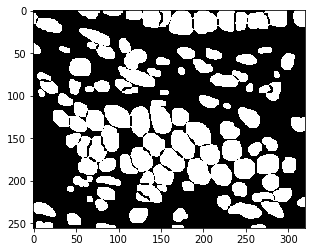

In [11]:
plt.imshow(target[:,:,0], cmap='gray')

In [14]:
target[:,:,2].mean()

152.05682373046875

In [ ]:
plt.imshow(target[:,:,0], cmap='gray')

In [ ]:
plt.imshow(target[:,:,1], cmap='gray')

In [ ]:
plt.imshow(target[:,:,2], cmap='gray')

In [ ]:
import glob
preprocess()

In [ ]:
import glob
config.PATIENCE = 5
config.KFOLDS = 1
config.BATCH_SIZE = 2
train(1, '', 1)

In [ ]:
def postprocess(weights):
    model = Unet()

    model.load_state_dict(torch.load(weights, map_location=lambda storage, location: storage))
    model.eval()

    model.cuda()
  
    kfolds = get_kfolds(2)
  
    dataset = TrainDataset(kfolds[0][0], augmentation=augmentation)
    dataLoader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS)

    for data in dataLoader:
        img, target = data['img'], data['target']

        x = Variable(img).cuda()
        y = Variable(target).cuda()

        outs = model(x)
#         break

    x = x.data.cpu().numpy()
    y = y.data.cpu().numpy()
    outs = outs.data.cpu().numpy()

    return x, y, outs
  
# x, y, outs = postprocess('model-45.pt')
x, y, outs = postprocess('model-kfold-0-best.pt')

from skimage.morphology import label, binary_dilation, erosion, binary_closing
from skimage.segmentation import random_walker

# outs[0][1] *= (255.0/outs[0][1].max())

mask = outs[0,0]
contour = outs[0,1]
    
mask = (mask*255).astype(np.uint8)
contour = (contour*255).astype(np.uint8)

_, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_OTSU)
_, contour = cv2.threshold(contour, 0, 255, cv2.THRESH_OTSU)

sure_foreground = (contour - mask)
sure_background = erosion(mask)

mask_plus_contour = cv2.add(mask, contour)
mask_plus_contour = cv2.cvtColor(mask_plus_contour, cv2.COLOR_GRAY2RGB)

unknown = cv2.subtract(sure_background, sure_foreground)

# Marker labelling
output = cv2.connectedComponentsWithStats(sure_foreground)
labels = output[1]
stats = output[2]
# Add one to all labels so that sure background is not 0, 0 is considered unknown by watershed
# this way, watershed can distinguish unknown from the background
labels = labels + 1
labels[unknown==255] = 0

labels = cv2.watershed(mask_plus_contour, labels)
# labels = random_walker(mask_plus_contour, labels, multichannel=True)   

labels[labels==-1] = 0
labels[labels==1] = 0
labels = labels -1
labels[labels==-1] = 0

mean = np.mean(stats[1:,cv2.CC_STAT_AREA])

for i in range(1, labels.max()):
     if stats[i, cv2.CC_STAT_AREA] > mean*10 or stats[i, cv2.CC_STAT_AREA] < mean/10:
        labels[labels==i] = 0

        
def renumber_labels(label_img):
    """ Re-number nuclei in a labeled image so the nuclei numbers are unique and consecutive.
    """
    new_label = 0
    for old_label in np.unique(label_img):
        if not old_label == new_label:
            label_img[label_img == old_label] = new_label
        new_label += 1
  
    return label_img


labels = renumber_labels(labels)
img = np.concatenate((outs[0][0:1].reshape(256, 256, 1), outs[0][1:2].reshape(256, 256, 1), (outs[0][2]).reshape(256, 256, 1)), axis=-1).reshape(256, 256, 3)
truth = np.concatenate((y[0][0:1].reshape(256, 256, 1), y[0][1:2].reshape(256, 256, 1), (y[0][2] > 0).astype(np.uint8).reshape(256, 256, 1)), axis=-1).reshape(256, 256, 3)
x = np.concatenate((x[0][0:1].reshape(256, 256, 1), x[0][1:2].reshape(256, 256, 1), (x[0][2]).reshape(256, 256, 1)), axis=-1).reshape(256, 256, 3)

plt.imshow(x)

In [ ]:
# x = x.reshape(3, 256, 256)
x = (x*255).astype(np.uint8)

img_lab = cv2.cvtColor(x, cv2.COLOR_RGB2Lab)
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
img_output = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

In [ ]:
plt.imshow(img_output)

In [ ]:
plt.imshow(truth)

In [ ]:
def rgb_clahe(in_rgb_img):
    grid_size = 8
#     in_rgb_img = (in_rgb_img*255).astype(np.uint8)
    bgr = in_rgb_img[:,:,[2,1,0]] # flip r and b
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(grid_size,grid_size))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr[:,:,[2,1,0]]

plt.imshow(rgb_clahe(x))
# x = x.reshape(256, 256, 3)

In [ ]:
x.shape

In [ ]:
plt.imshow(x.reshape(256, 256, 3))

In [ ]:
# x = x.astype(np.uint8)
skimage.exposure.equalize_adapthist(x[:,:,0])
# x[:,:,0]

In [ ]:
!rm -rf ./targets